In [104]:
import requests

In [105]:
url = 'http://www-app3.gfz-potsdam.de/kp_index/Kp_ap_nowcast.txt'
res = requests.get(url)
res.raise_for_status()  # Ensure we notice bad responses

text = res.text
lines = text.splitlines()

In [106]:
lines

['# PURPOSE: This file distributes the Kp index and ap index (one line per three-hour interval)',
 '# LICENSE: CC BY 4.0',
 '# SOURCE: Geomagnetic Observatory Niemegk, GFZ Helmholtz Centre for Geosciences',
 '# PLEASE CITE: Matzka, J., Stolle, C., Yamazaki, Y., Bronkalla, O. and Morschhauser, A., 2021. The geomagnetic Kp index ',
 '# and derived indices of geomagnetic activity. Space Weather, https://doi.org/10.1029/2020SW002641',
 '#',
 '# Kp, ap and Ap',
 '# The three-hourly equivalent planetary amplitude ap is derived from Kp and the daily equivalent planetary amplitude Ap is the daily mean of ap.',
 '# Kp is unitless. Ap and ap are unitless and can be multiplied by 2 nT to yield the average geomagnetic disturbance at 50 degree geomagnetic latitude.',
 '# Kp, ap and Ap were introduced by Bartels (1949, 1957) and are produced by Geomagnetic Observatory Niemegk, GFZ Helmholtz Centre for Geosciences.',
 '# Described in: Matzka et al. (2021), see reference above.',
 '# Data publication:

In [107]:
data = []
for line in lines:
    if line.startswith('#'):
        if '#YYY' in line:
            data.append(line)
        else:
            continue
    else:
        data.append(line)

In [108]:
header = data[0]
rows = data[1:]
print(header)
header = header.replace('#', '').strip()
print(header.split())

#YYY MM DD hh.h hh._m        days      days_m     Kp   ap D
['YYY', 'MM', 'DD', 'hh.h', 'hh._m', 'days', 'days_m', 'Kp', 'ap', 'D']


In [109]:
import pandas as pd

In [110]:
df = pd.DataFrame(
    [row.split() for row in rows],
    columns=header.split()
)
df

,YYY,MM,DD,hh.h,hh._m,days,days_m,Kp,ap,D
0,2025,10,18,00.0,01.50,34259.00000,34259.06250,3.333,18,0
1,2025,10,18,03.0,04.50,34259.12500,34259.18750,4.333,32,0
2,2025,10,18,06.0,07.50,34259.25000,34259.31250,4.667,39,0
3,2025,10,18,09.0,10.50,34259.37500,34259.43750,4.000,27,0
4,2025,10,18,12.0,13.50,34259.50000,34259.56250,3.333,18,0
...,...,...,...,...,...,...,...,...,...,...
235,2025,11,16,09.0,10.50,34288.37500,34288.43750,-1.000,-1,0
236,2025,11,16,12.0,13.50,34288.50000,34288.56250,-1.000,-1,0
237,2025,11,16,15.0,16.50,34288.62500,34288.68750,-1.000,-1,0
238,2025,11,16,18.0,19.50,34288.75000,34288.81250,-1.000,-1,0


In [111]:
df['date'] = df['YYY'] + '-' + df['MM'] + '-' + df['DD'] + 'T' + df['hh.h']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H.%M')
df['Kp'] = pd.to_numeric(df['Kp'], errors='coerce')
df['Kp'] = df['Kp'].replace(-1, None)

In [112]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [113]:
tnow = pd.Timestamp.now(tz='UTC')
tnow = tnow.replace(hour=0, minute=0, second=0, microsecond=0)
tnow

Timestamp('2025-11-16 00:00:00+0000', tz='UTC')

In [114]:
df = df.dropna(subset=['Kp'])

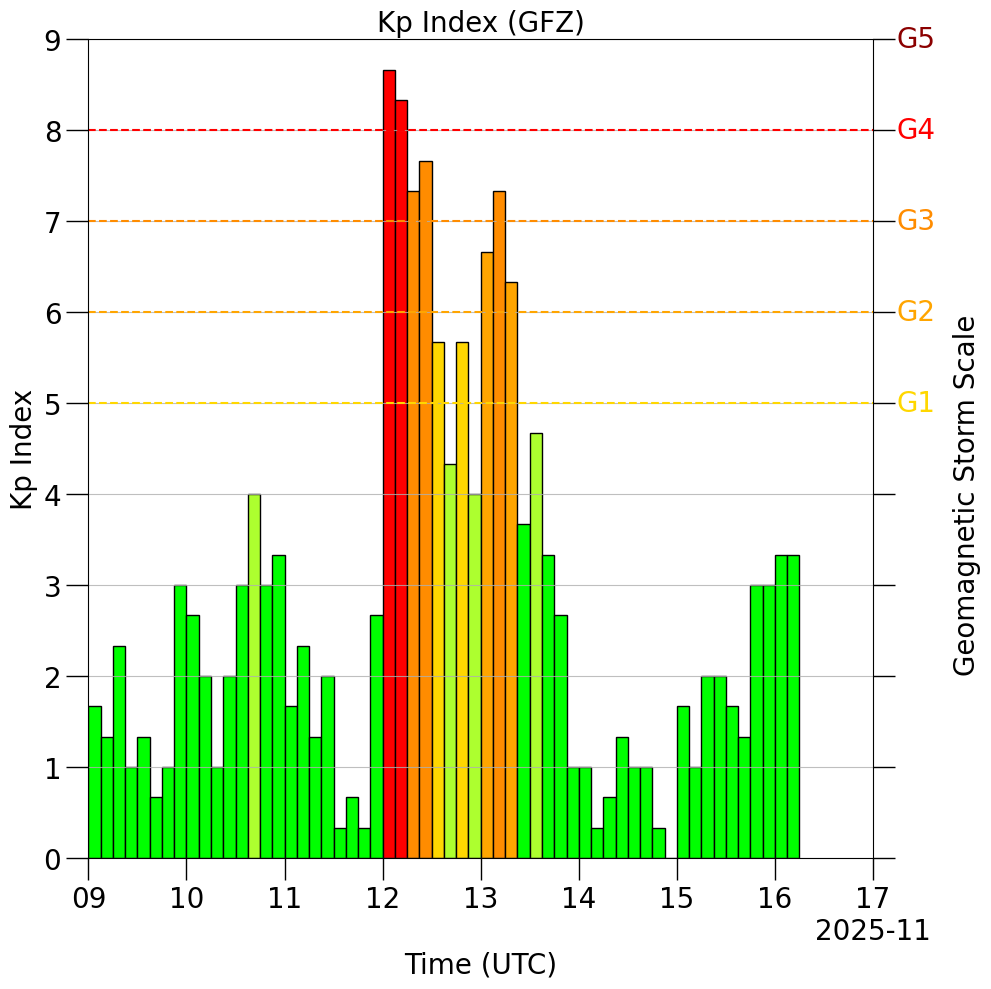

In [115]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
bar_width = 3/24
colors = []
for v in df['Kp'].values:
    if v < 4:
        colors.append("lime")
    elif v < 5:
        colors.append("greenyellow")
    elif v < 6:
        colors.append("gold")
    elif v < 7:
        colors.append("orange")
    elif v < 8:
        colors.append("darkorange")
    elif v < 9:
        colors.append("red")
    else:
        colors.append("darkred")
    
ax.bar(df['date'], df['Kp'], width=bar_width, align='edge', color=colors, edgecolor='k')
ax.set_ylabel("Kp Index", fontsize=20)
ax.set_xlabel("Time (UTC)", fontsize=20)
ax.set_title("Kp Index (GFZ)", fontsize=20)
ax.set_ylim(0, 9)
ax.set_yticks(range(0, 10))
ax.tick_params(axis='both', which='major', labelsize=20, length=16, width=1)
ax.tick_params(axis='both', which='minor', labelsize=20, length=8, width=1)
ax.tick_params(axis='y', which='both', right=True)

def custom_formatter(x, pos):
    ticks = ax.get_xticks()
    if len(ticks) == 0:
        return ""
    
    # Last tick (end of day)
    if abs(x - ticks[-1]) < 1e-6:
        dt = mdates.num2date(x)
        ym = dt.strftime("%Y-%m")
        d = dt.strftime("%d")
        return f"{d}\n{ym}"
    
    # Other ticks (day of month)
    dt = mdates.num2date(x)
    return dt.strftime("%d")

ax.xaxis.set_major_formatter(custom_formatter)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.set_xlim(tnow - pd.Timedelta(days=7), tnow + pd.Timedelta(days=1))

ax.grid(True, which='major', axis='y', linestyle='-', alpha=0.8)

ax.axhline(5, color='gold', linestyle='--', zorder=2)
ax.text(1.03, 5, 'G1', color='gold', fontsize=20, 
        va='center', transform=ax.get_yaxis_transform())
ax.axhline(6, color='orange', linestyle='--', zorder=2)
ax.text(1.03, 6, 'G2', color='orange', fontsize=20, 
        va='center', transform=ax.get_yaxis_transform())
ax.axhline(7, color='darkorange', linestyle='--', zorder=2)
ax.text(1.03, 7, 'G3', color='darkorange', fontsize=20, 
        va='center', transform=ax.get_yaxis_transform())
ax.axhline(8, color='red', linestyle='--', zorder=2)
ax.text(1.03, 8, 'G4', color='red', fontsize=20, 
        va='center', transform=ax.get_yaxis_transform())
ax.text(1.03, 9, 'G5', color='darkred', fontsize=20, 
        va='center', transform=ax.get_yaxis_transform())
ax.text(1.12, 4, 'Geomagnetic Storm Scale', rotation=90, fontsize=20, 
        va='center', ha='center', transform=ax.get_yaxis_transform())

fig.tight_layout()
plt.show()
# plt.savefig('kp_index.png', dpi=300, bbox_inches='tight')
# plt.close(fig)
# Image('kp_index.png')